import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.

## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer
Put your answer here...

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the bostom dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [1]:
import numpy as np
from scipy.ndimage.interpolation import shift
from sklearn.datasets import load_boston

In [2]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.is_leaf = False


class DecisionTreeClassifier:
    def __init__(self, max_depth=50, min_leaf=1):
        self.max_depth = max_depth
        self.min_leaf = min_leaf

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= self.min_leaf:
            return None, None
        _, num_parent = np.unique(y, return_counts=True)
        best_error = np.inf
        best_idx, best_thr = None, None
        for idx in range(self.n_features_):
            sort_idx = np.argsort(X[:, idx])
            thresholds = X[sort_idx, idx]
            thresholds = thresholds[self.min_leaf:-self.min_leaf+1]
            for thresh in thresholds:
                left = y[X[:, idx] < thresh]
                right = y[X[:, idx] >= thresh]
                left_error = np.sum(np.abs(left - left.mean()))
                right_error = np.sum(np.abs(right - right.mean()))
                error = left_error + right_error
                if error < best_error:
                    best_error = error
                    best_idx, best_thr = idx, thresh
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        predicted_class = y.mean()
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class    

In [3]:
class TreeEnsemble():
    def __init__(self, n_trees=10, sample_sz=750, min_leaf=5, max_depth=50):
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.max_depth = max_depth
  
    def fit(self, X, y):
        self.trees = {}
        self.X = X
        self.y = y
        for i in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_leaf=self.min_leaf)
            sample = np.random.randint(0, high=X.shape[0], size=self.sample_sz)
            X_sample = X[sample, :]
            y_sample = y[sample]
            out_of_sample = np.array(list(set(np.arange(X.shape[0])).difference(sample)))
            tree.fit(X_sample, y_sample)
            self.trees[i] = {'tree': tree, 'sample': sample, 'out_sample': np.array(out_of_sample)}
            
    def predict(self, X):
        y_pred = np.zeros((X.shape[0]))
        for tree in self.trees.values():
            y_pred += tree['tree'].predict(X)
        return y_pred/self.n_trees
    
    def oob_mse(self):
        score = 0
        for tree in self.trees.values():
            X_test = self.X[tree['out_sample'].reshape(-1),:]
            y_test = self.y[tree['out_sample'].reshape(-1)]
            y_test_pred = tree['tree'].predict(X_test)
            score += np.sum((y_test_pred - y_test)**2)
        return score/self.n_trees

In [4]:
X, y = load_boston(return_X_y=True)

In [5]:
best_mse = np.inf
best_forest = None
for n in [1,5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(n_trees=n, sample_sz=sz, min_leaf=min_leaf)
            forest.fit(X, y)
            mse = forest.oob_mse()
            if mse < best_mse:
                best_mse = mse
                best_forest = forest
            print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

n_trees:1, sz:50, min_leaf:1 --- oob mse: 38566.394752
n_trees:1, sz:50, min_leaf:5 --- oob mse: 18731.547133333326
n_trees:1, sz:100, min_leaf:1 --- oob mse: 33736.438191999994


/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice.
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


n_trees:1, sz:100, min_leaf:5 --- oob mse: 13827.142363890463
n_trees:1, sz:300, min_leaf:1 --- oob mse: 23812.668919555555
n_trees:1, sz:300, min_leaf:5 --- oob mse: 5370.643931067334
n_trees:1, sz:500, min_leaf:1 --- oob mse: 15871.684449919998


/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice.


n_trees:1, sz:500, min_leaf:5 --- oob mse: 3468.3318154289495
n_trees:5, sz:50, min_leaf:1 --- oob mse: 40069.2975152
n_trees:5, sz:50, min_leaf:5 --- oob mse: 15405.260950622955
n_trees:5, sz:100, min_leaf:1 --- oob mse: 35833.80423
n_trees:5, sz:100, min_leaf:5 --- oob mse: 13425.732252909107
n_trees:5, sz:300, min_leaf:1 --- oob mse: 24364.77912482222
n_trees:5, sz:300, min_leaf:5 --- oob mse: 6399.1487550059655
n_trees:5, sz:500, min_leaf:1 --- oob mse: 17083.396227816
n_trees:5, sz:500, min_leaf:5 --- oob mse: 5106.008739362971
n_trees:10, sz:50, min_leaf:1 --- oob mse: 39223.8876268
n_trees:10, sz:50, min_leaf:5 --- oob mse: 18837.09582278455
n_trees:10, sz:100, min_leaf:1 --- oob mse: 35322.836042099996
n_trees:10, sz:100, min_leaf:5 --- oob mse: 12587.064088731737
n_trees:10, sz:300, min_leaf:1 --- oob mse: 23442.47169762222
n_trees:10, sz:300, min_leaf:5 --- oob mse: 7361.445950522892
n_trees:10, sz:500, min_leaf:1 --- oob mse: 15805.918627899999
n_trees:10, sz:500, min_leaf:5

<IPython.core.display.Javascript object>

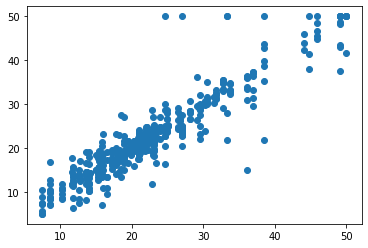

In [6]:
y_hat = best_forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y);

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

Using TensorFlow backend.


We want to optimize the gain function, max depth, minimum samples per leaf, max features for both Decision Tree and the Random Forest classifiers, as well as n_estimators for Random Forest. We also want to optimize the binarization threshold. 

We optimize these parameters by chaining the Binarizer and Classifiers into a pipeline and then running Grid Search, which essentially iterates over all of the possible combinations of parameter settings we provide and chooses the parameter combination which results in the best Cross Validation score.

The grid_search object stores the best parameters which can then be used to train the final model.

However, it took an unpracticable long time to do even a limited trial of all of the options: a full search of multiple configurations of each parameter (involving more than 2000 different instances) had not finished running after 3 days, so we restricted the search to the parameters indicated below.

In [33]:
binarizer = Binarizer()
forest_clf = RandomForestClassifier()
forest_pipe = make_pipeline(binarizer, forest_clf)

forest_parameters = {
    'binarizer__threshold': (0, 50, 100),
    'randomforestclassifier__max_depth': (None, 10, 50),
    'randomforestclassifier__min_samples_leaf': (1,5),
    'randomforestclassifier__max_features': ('sqrt','log2')
}

forest_grid_search = GridSearchCV(forest_pipe, forest_parameters, verbose=1)
forest_grid_search.fit(X_train, y_train)
print("Best score: %0.3f" % forest_grid_search.best_score_)
print("Best parameters set:")
forest_best_parameters = forest_grid_search.best_estimator_.get_params()
for param_name in sorted(forest_parameters.keys()):
    print("\t%s: %r" % (param_name, forest_best_parameters[param_name]))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 52.0min finished


Best score: 0.968
Best parameters set:
	binarizer__threshold: 50
	randomforestclassifier__max_depth: None
	randomforestclassifier__max_features: 'sqrt'
	randomforestclassifier__min_samples_leaf: 1


In [34]:
binarizer = Binarizer()
tree_clf = DecisionTreeClassifier()
tree_pipe = make_pipeline(binarizer, tree_clf)

tree_parameters = {
    'binarizer__threshold': (0, 50, 100),
    'decisiontreeclassifier__max_depth': (None, 10, 50),
    'decisiontreeclassifier__min_samples_leaf': (1,5),
    'decisiontreeclassifier__max_features': ('sqrt','log2', None),
}

tree_grid_search = GridSearchCV(tree_pipe, tree_parameters, verbose=1)
tree_grid_search.fit(X_train, y_train)
print("Best score: %0.3f" % tree_grid_search.best_score_)
print("Best parameters set:")
tree_best_parameters = tree_grid_search.best_estimator_.get_params()
for param_name in sorted(tree_parameters.keys()):
    print("\t%s: %r" % (param_name, tree_best_parameters[param_name]))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 15.8min finished


Best score: 0.876
Best parameters set:
	binarizer__threshold: 0
	decisiontreeclassifier__max_depth: 50
	decisiontreeclassifier__max_features: None
	decisiontreeclassifier__min_samples_leaf: 1


In [ ]:
binarizer = Binarizer(threshold=0)
tree_clf = DecisionTreeClassifier(max_depth=50, max_features=None, min_samples_leaf=1)
tree_pipe = make_pipeline(binarizer, tree_clf)
tree_pipe.fit(X_train, y_train)
tree_importances = tree_clf.feature_importances_
tree_indices = np.argsort(tree_importances)[::-1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

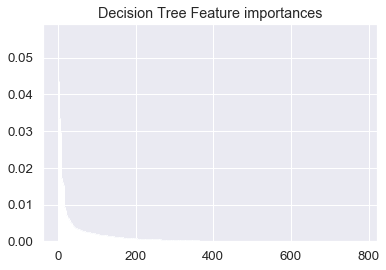

In [21]:
plt.title("Decision Tree Feature importances")
plt.bar(range(X_train.shape[1]), tree_importances[tree_indices])
plt.show();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The accuracy of our confusion matrix is:  0.8899
The accuracy for label 0 is 0.9388
The accuracy for label 1 is 0.9665
The accuracy for label 2 is 0.8886
The accuracy for label 3 is 0.8624
The accuracy for label 4 is 0.9043
The accuracy for label 5 is 0.8352
The accuracy for label 6 is 0.9029
The accuracy for label 7 is 0.9056
The accuracy for label 8 is 0.8018
The accuracy for label 9 is 0.8761


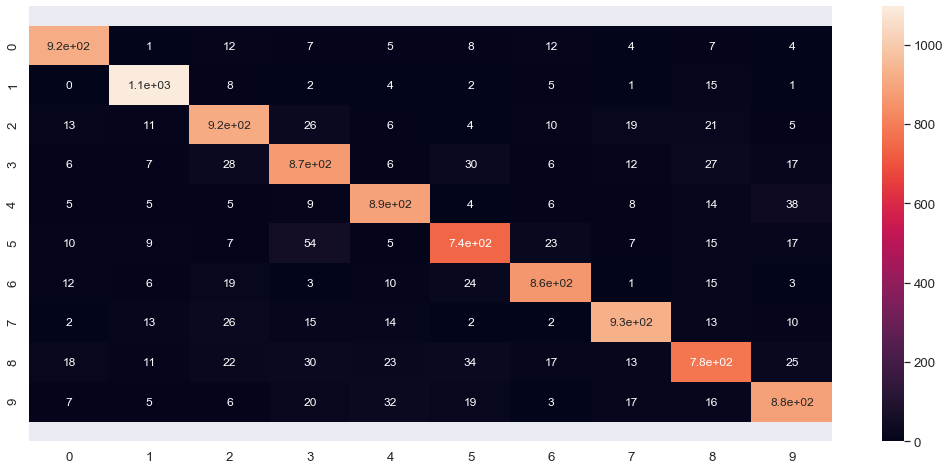

In [9]:
y_pred = tree_clf.predict(binarizer.transform(X_test))

cfm = np.array(confusion_matrix(y_test,y_pred))
df_cm = pd.DataFrame(cfm, range(10),
                  range(10))
plt.figure(figsize = (18,8))
sns.set(font_scale=1.2)#for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

#To calculate accuracy:
diagonal_sum = cfm.trace()
sum_of_all_elements = cfm.sum()
print("The accuracy of our confusion matrix is: ", diagonal_sum / sum_of_all_elements)

for i in range(0,10):
    acc_i = np.round(cfm[i,i]/sum(cfm[i,:]),4)
    print("The accuracy for label {} is {}".format(i, acc_i))

In [13]:
binarizer = Binarizer(threshold=50)
forest_clf = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=1)
forest_pipe = make_pipeline(binarizer, forest_clf)

forest_pipe.fit(X_train, y_train)
forest_importances = forest_clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_],axis=0)
forest_indices = np.argsort(forest_importances)[::-1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

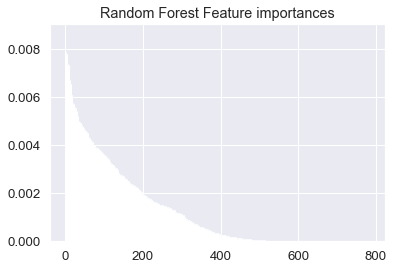

In [20]:
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), forest_importances[forest_indices])
plt.show();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The accuracy of our confusion matrix is:  0.9701
The accuracy for label 0 is 0.9898
The accuracy for label 1 is 0.9912
The accuracy for label 2 is 0.968
The accuracy for label 3 is 0.9644
The accuracy for label 4 is 0.9715
The accuracy for label 5 is 0.9608
The accuracy for label 6 is 0.9812
The accuracy for label 7 is 0.9591
The accuracy for label 8 is 0.961
The accuracy for label 9 is 0.9514


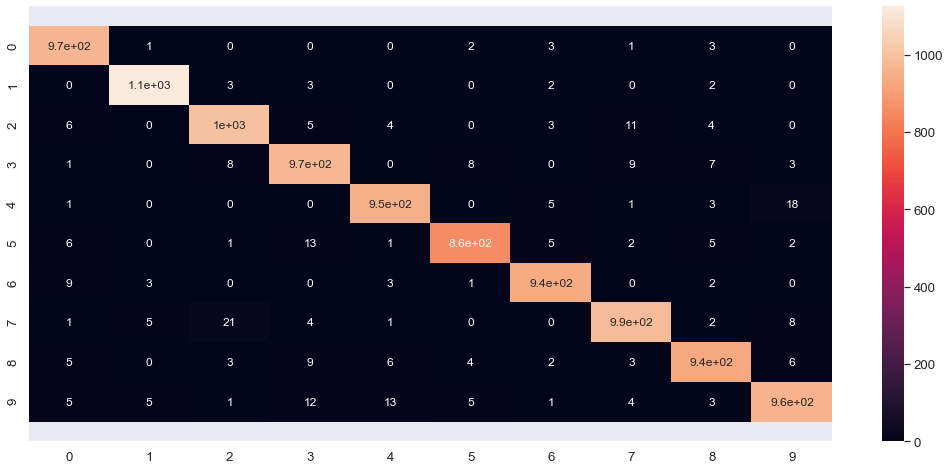

In [11]:
y_pred = forest_clf.predict(binarizer.transform(X_test))

cfm = np.array(confusion_matrix(y_test,y_pred))
df_cm = pd.DataFrame(cfm, range(10),
                  range(10))
plt.figure(figsize = (18,8))
sns.set(font_scale=1.2)#for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

#To calculate accuracy:
diagonal_sum = cfm.trace()
sum_of_all_elements = cfm.sum()
print("The accuracy of our confusion matrix is: ", diagonal_sum / sum_of_all_elements)

for i in range(0,10):
    acc_i = np.round(cfm[i,i]/sum(cfm[i,:]),4)
    print("The accuracy for label {} is {}".format(i, acc_i))

Comparing the confusion matrices from the decision tree vs. random forest it is clear that the Random Forest Classifier generalizes much better to the test data than the decision tree. The Decision Tree has a hard time distinguising between 3 and 5 (much like the Naive Bayes classifier), although the Random Forest does a much better job.

When it comes to feature importance we see that the Decision Tree has much more of a power law distribution in comparison to the Random Forest, suggesting that the decision tree manages to capture fewer informative features than the Random Forest, which aligns with their respective performance

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/